In [74]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/mssmartypants/rice-type-classification'
od.download(dataset_url)

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [75]:
import torch
import torch.nn as nn #neural network
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [76]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [77]:
data_df.dropna(inplace= True)
data_df.drop(['id'],axis=1,inplace=True)
print(data_df.shape)

(18185, 11)


In [78]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [79]:
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:,-1])

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3)

In [81]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test ,test_size = 0.5)

In [82]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [83]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = torch.tensor(X,dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y,dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]


In [84]:
training_data = dataset(X_train,Y_train)
validation_data = dataset(X_val,Y_val)
testing_data = dataset(X_test,Y_test)

In [85]:
train_dataloader = DataLoader(training_data, batch_size = 32,shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 32,shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = 32,shuffle = True)

In [93]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel,self).__init__()
    self.input_layer = nn.Linear(X.shape[1],HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x
model = MyModel().to(device)

In [94]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [95]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr = 1e-3)

In [89]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []
epochs = 10
for epoch in range(epochs):
  total_loss_train = 0
  total_loss_validation = 0
  total_acc_train = 0
  total_acc_validation = 0
  for data in train_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_train += acc
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  with torch.no_grad():
    for data in validation_dataloader:
      inputs , labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_validation += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()
      total_acc_validation += acc
  total_loss_train_plot.append(round(total_loss_train/len(train_dataloader),4))
  total_loss_validation_plot.append(round(total_loss_validation/len(validation_dataloader),4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4 ))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__()*100,4 )) # Corrected this line
  print(f'Epoch no. {epoch+1} Train loss: {round(total_loss_train/len(train_dataloader),4)},Train accuracy: {round(total_acc_train/training_data.__len__()*100,4)},Validation Loss:{round(total_loss_validation/len(validation_dataloader),4)},Validation accuracy:{round(total_acc_validation/validation_data.__len__()*100,4)}%') # Corrected print statement

Epoch no. 1 Train loss: 0.5919,Train accuracy: 80.2027,Validation Loss:0.4479,Validation accuracy:98.0205%
Epoch no. 2 Train loss: 0.2959,Train accuracy: 97.9417,Validation Loss:0.1881,Validation accuracy:98.0938%
Epoch no. 3 Train loss: 0.1384,Train accuracy: 98.256,Validation Loss:0.1048,Validation accuracy:98.7537%
Epoch no. 4 Train loss: 0.0892,Train accuracy: 98.4759,Validation Loss:0.0751,Validation accuracy:98.827%
Epoch no. 5 Train loss: 0.0691,Train accuracy: 98.5152,Validation Loss:0.061,Validation accuracy:98.7537%
Epoch no. 6 Train loss: 0.059,Train accuracy: 98.5623,Validation Loss:0.0532,Validation accuracy:98.7537%
Epoch no. 7 Train loss: 0.0533,Train accuracy: 98.5623,Validation Loss:0.0519,Validation accuracy:98.607%
Epoch no. 8 Train loss: 0.0498,Train accuracy: 98.5938,Validation Loss:0.0457,Validation accuracy:98.7537%
Epoch no. 9 Train loss: 0.0474,Train accuracy: 98.5781,Validation Loss:0.0437,Validation accuracy:98.9003%
Epoch no. 10 Train loss: 0.0462,Train accu

In [90]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs , labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction, labels)
    total_loss_test += batch_loss_test

    acc_test = ((prediction).round() == labels).sum().item()
    total_acc_test += acc_test

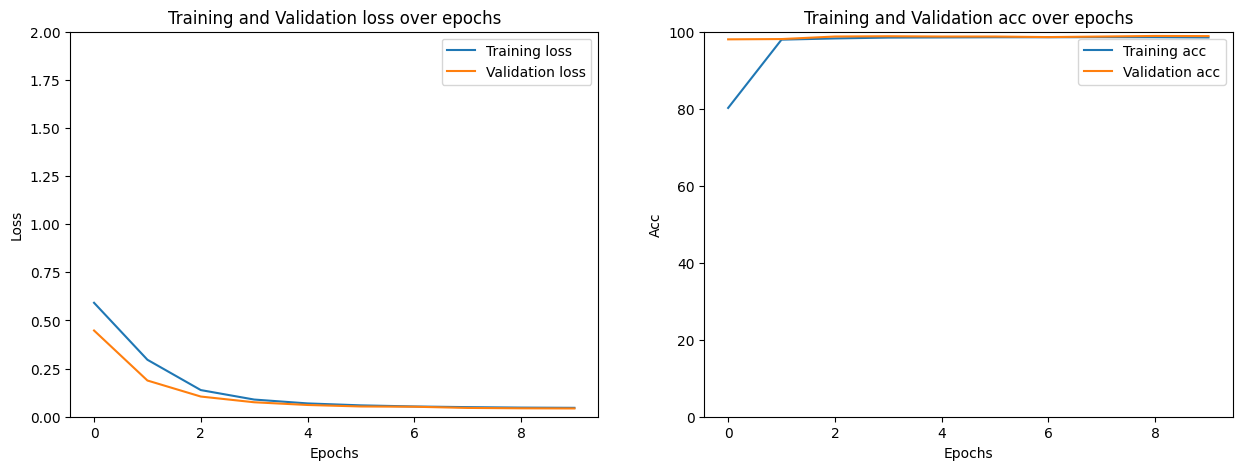

In [97]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize =(15,5))
axs[0].plot(total_loss_train_plot,label = "Training loss")
axs[0].plot(total_loss_validation_plot,label = "Validation loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot,label = "Training acc")
axs[1].plot(total_acc_validation_plot,label = "Validation acc")
axs[1].set_title("Training and Validation acc over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Acc")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

